### Problem Statement

Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.
Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017,
920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR)
by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams.
Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of
pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid
overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-
radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also
appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at
different time points and correlation with clinical symptoms and history are helpful in making the
diagnosis.
CXRs are the most commonly performed diagnostic imaging study. A number of factors such as
positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating
interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.
Pneumonia Detection
Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re
challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically,
your algorithm needs to automatically locate lung opacities on chest radiographs.

### Objectives

The objective of the project is,
- Learn to how to do build an Object Detection Model
- Use transfer learning to fine-tune a model.
- Learn to
- Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.

#### Import the Libraries

In [1]:
pip install segmentation_models

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow as tf
import os
import pydicom
import cv2
from glob import glob

from matplotlib.patches import Rectangle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

#Mobile Net
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Input, Concatenate, Conv2D,Dense,Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Model,Sequential
import segmentation_models
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.models import Model # to join the two models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from tensorflow.keras.losses import binary_crossentropy
from tqdm import tqdm_notebook
from tqdm import tqdm
import seaborn as sns
import math
import random
from keras.utils.vis_utils import plot_model
from sklearn.utils import resample


from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import VGG19
#from skimage.transform import resize

import keras
import math
random_state = 2020


# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


#### Image Properties Below

#### Change to the current project directory

In [4]:
os.chdir('/Volumes/Ayon_Drive/GreatLearning/Capstone_Pneumonia/')

#### Name of training and test images and bounding box details below

In [5]:
DET_CLASS_INFO = 'stage_2_detailed_class_info.csv'
TRAIN_BBOX = 'stage_2_train_labels.csv'
TRAIN_IMG_DCM = "stage_2_train_images"
TEST_IMG_DCM = "stage_2_test_images"
TRAIN_IMG_DIR_JPG = 'JPG_train'
TEST_IMG_DIR_JPG = 'JPG_test'

### Pre-Processing, Data Visualization, EDA

### Exploratory Data Analysis (EDA) Here as a part of EDA, we will:

Start with understanding of the data with a brief on train/test labels and respective class info Look at the first five rows of both the csvs (train and test) Identify how are classes and target distributed Check the number of patients with 1, 2, ... bounding boxes Read and extract metadata from dicom files Perform analysis on some of the features from dicom files Check some random images from the training dataset Draw insights from the data at various stages of EDA

Reading CSVs Images for the current stage in the stage_2_train_images and stage_2_test_images. Training data: stage_2_train_labels.csv stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

#### Loading detailed class info file

In [6]:
class_df = pd.read_csv(DET_CLASS_INFO)

In [7]:
print("\nClass dataframe has 30227 rows and 2 columns:")
class_df.shape


Class dataframe has 30227 rows and 2 columns:


(30227, 2)

In [8]:
print("\nClass dataframe first 5 rows:")
class_df.head()


Class dataframe first 5 rows:


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
print('Total No of Patients in Class Info', class_df['patientId'].value_counts().shape[0])

Total No of Patients in Class Info 26684


In [10]:
print('Total distinct classes: ', class_df['class'].unique())

Total distinct classes:  ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


#### We see there are 3 classes, Normal, Lung Opacity and No Lung Opacity/Not Normal
#### No Lung Opacity/Not Normal are cases that look like opacity but are not. 

#### Check for duplicates in patient id

In [11]:
##Identify duplicates records in the data
dupes = class_df['patientId'].duplicated()
sum(dupes)

3543

#### 3543 patients have duplicates in class info

<AxesSubplot:xlabel='class'>

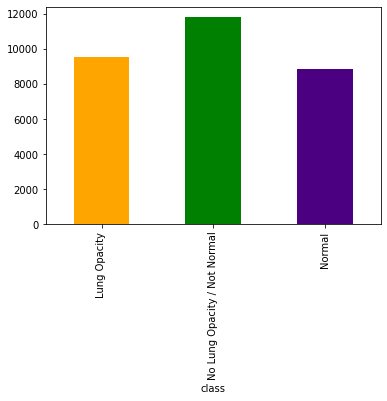

In [12]:
class_df.groupby('class').size().plot.bar(5, 10, color=['Orange', 'green', 'Indigo'])

#### Load CSV file containing training set patientIds and labels (Bounding Boxes)

In [13]:
labels_df = pd.read_csv(TRAIN_BBOX)

In [14]:
print("\nLabel dataframe first 5 rows:")
labels_df.head()


Label dataframe first 5 rows:


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


#### We see patient ids, and bounding box is present in the dataset. 0 means No Pneumonia, 1 means Pneumonia
#### Bounding Box is not present when the patient doesnot have pneumonia, however 0 can mean No Lung Opacity/Not Normal¶

In [15]:
print(f'Train Labels dataframe has {labels_df.shape[0]} rows and {labels_df.shape[1]} columns')

Train Labels dataframe has 30227 rows and 6 columns


#### Converting Not a number to 0

In [16]:
labels_df['x'] = labels_df['x'].replace(np.nan, 0)
labels_df['y'] = labels_df['y'].replace(np.nan, 0)
labels_df['width'] = labels_df['width'].replace(np.nan, 0)
labels_df['height'] = labels_df['height'].replace(np.nan, 0)

In [17]:
print("\nUpdated data samples:")
labels_df.head()


Updated data samples:


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


#### There are 30,227 patient ids

#### Checking the dataset information

In [18]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [19]:
labels_df.describe()

,x,y,width,height,Target
count,30227.000000,30227.000000,30227.000000,30227.000000,30227.000000
mean,124.561683,115.960962,69.060575,104.084825,0.316108
std,216.326397,190.012883,106.910496,176.932152,0.464963
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,193.000000,231.000000,169.000000,188.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


#### Checking duplicates if it matches with class info file

In [20]:
##Identify duplicates records in the data
dupes = labels_df['patientId'].duplicated()
sum(dupes)

3543

#### 3543 patients have multiple X rays

#### Check for missing values

In [21]:
print(" \nCount total NaN at each column in the dataset : \n\n", 
      labels_df.isnull().sum())

 
Count total NaN at each column in the dataset : 

 patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64


#### From the above we see there are no null values

Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


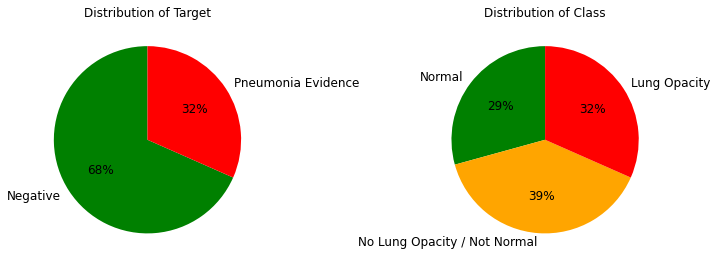

In [22]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (labels_df['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['green', 'red'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_df['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['green', 'orange', 'red'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

### We will check the number of boxes for each patient

In [23]:
box_patient_df = labels_df.groupby('patientId').size().reset_index(name='boxes')
box_patient_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


In [24]:
labels_class_df = pd.merge(labels_df, class_df, how='inner', on='patientId')
print('Total Cases : ', labels_class_df.shape[0])

Total Cases :  37629


#### Since there are duplicate patient ids in both the datasets we see an increase in the number of rows
#### Instead of doing inner join lets try to concat both the datasets

In [25]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(class_df.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class_df = pd.concat([labels_df, class_df['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class_df.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 7)


In [26]:
train_class_df.head(5)


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


#### Observations from the CSVs Based on analysis above, some of the observations:

Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height. There are multiple records for patients. Number of duplicates in patientID = 3,543. There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia. Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity. Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class. Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class. About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!!!!

Reading Images Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [27]:
def checkXray(i, dirName):
    patientId = train_class_df['patientId'][i]
    print("Patient Id: ", patientId)
    fileName = dirName + "/" + patientId
    print("\nBounding Box Coordinates, X: ", train_class_df['x'][i])
    print("\nBounding Box Coordinates, Y: ", train_class_df['y'][i])
    print("\nBounding Box Coordinates, Width: ", train_class_df['width'][i])
    print("\nBounding Box Coordinates, Height: ", train_class_df['height'][i])
    
    patient_file = '%s.dcm' % fileName
    patient_data = pydicom.read_file(patient_file)
    print(patient_data)
    
    plt.imshow(patient_data.pixel_array,cmap=pl.cm.gist_gray)

#### Let's take a look into an image of a person who has normal lungs

Patient Id:  003d8fa0-6bf1-40ed-b54c-ac657f8495c5

Bounding Box Coordinates, X:  0.0

Bounding Box Coordinates, Y:  0.0

Bounding Box Coordinates, Width:  0.0

Bounding Box Coordinates, Height:  0.0
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2293.1517874295.733882
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(000

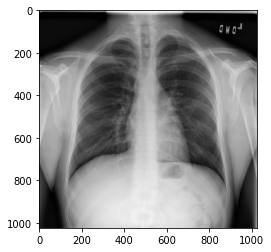

In [28]:
checkXray(3, TRAIN_IMG_DCM)

#### Let's take a look into an image of a person who has lung opacity

Patient Id:  00436515-870c-4b36-a041-de91049b9ab4

Bounding Box Coordinates, X:  264.0

Bounding Box Coordinates, Y:  152.0

Bounding Box Coordinates, Width:  213.0

Bounding Box Coordinates, Height:  379.0
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Stor

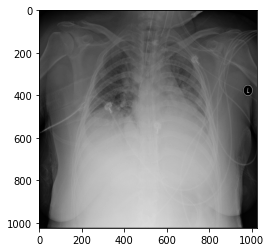

In [29]:
checkXray(4, TRAIN_IMG_DCM)

#### Let's take a look into an image of a person who has No Lung Opacity/Not Normal¶

Patient Id:  0004cfab-14fd-4e49-80ba-63a80b6bddd6

Bounding Box Coordinates, X:  0.0

Bounding Box Coordinates, Y:  0.0

Bounding Box Coordinates, Width:  0.0

Bounding Box Coordinates, Height:  0.0
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(00

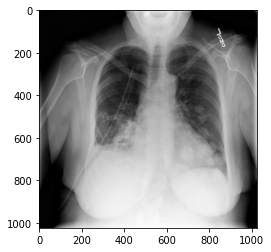

In [30]:
checkXray(0, TRAIN_IMG_DCM)

In [31]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = pydicom.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality

In [32]:
print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMG_DCM, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
assert images.shape[0] == len(list(set(train_class_df['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
--------------------------------------------------------------------------------
Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [33]:
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*40)
train_class_df = train_class_df.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class_df.shape))

Merge path from the `images` dataframe with `train_class` dataframe
--------------------------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 8)


In [34]:
train_class_df.head()

,patientId,x,y,width,height,Target,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...


In [35]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
if os.path.isfile('train_feature_engineered.pkl') :
    print('File exists..So we have the data')
else:
    get_tags(train_class_df, TRAIN_IMG_DCM)
    train_class_df.to_pickle('train_feature_engineered.pkl')

print('Saving the feature engineered dataframe for future use'); print('--'*40)


Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images
File exists..So we have the data
Saving the feature engineered dataframe for future use
--------------------------------------------------------------------------------


In [36]:
train_class_df = pd.read_pickle('train_feature_engineered.pkl')
train_class_df.shape

(30227, 13)

In [37]:
train_class_df.head()

,patientId,x,y,width,height,Target,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,F,32.0,CHEST,AP,CR


In [38]:
print('As expected unique in `BodyPartExamined` is: {}'.format(train_class_df['BodyPartExamined'].unique()[0]))
print('Unique in `Modality` is: {}'.format(train_class_df['Modality'].unique()[0])); print('--'*40)

As expected unique in `BodyPartExamined` is: CHEST
Unique in `Modality` is: CR
--------------------------------------------------------------------------------


Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------


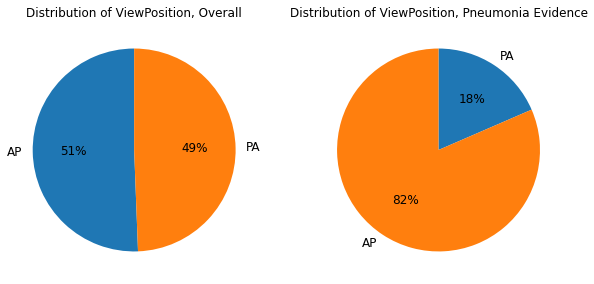

In [39]:
print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class_df['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class_df.loc[train_class_df['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Plot x and y centers of bounding boxes
--------------------------------------------------------------------------------


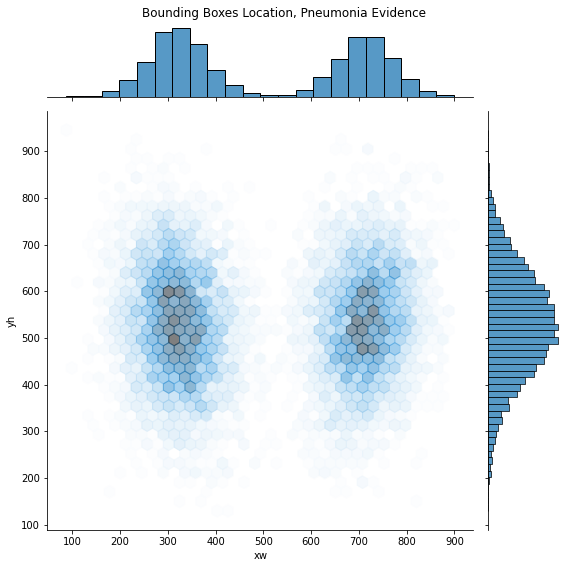

In [40]:
print('Plot x and y centers of bounding boxes'); print('--'*40)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class_df[train_class_df['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

In [41]:
# Helper function to plot bboxes scatter
# Reference for this function & plots: https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000


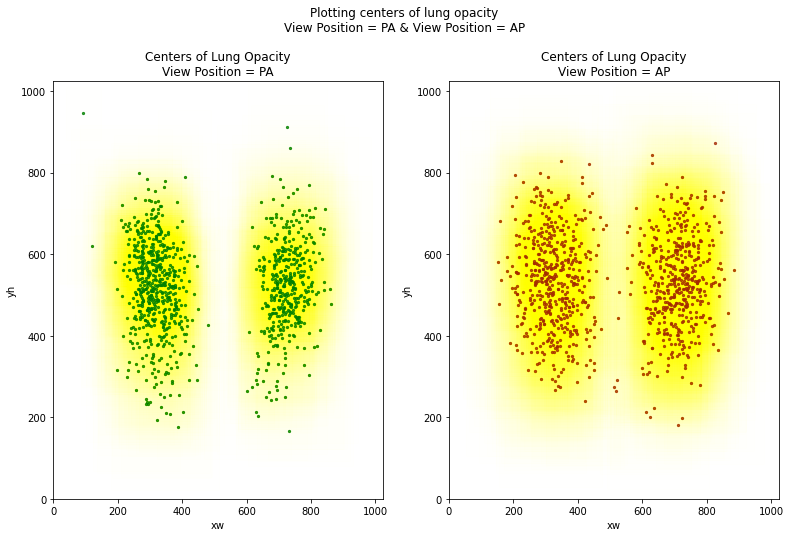

In [42]:
print('Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000')

df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

#### Observations: BodyPartExamined & ViewPosition Above we saw,

BodyPartExamined is unique for all cases and is CHEST in the training dataset and that was also expected. Unique in Modality is CR i.e. Computer Radiography Overall ViewPosition is almost equally distributed in the training dataset but for cases where Target=1, most of the view position are AP.

Checking outliers in `PatientAge
--------------------------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1.0
Maximum `PatientAge` in the training dataset: 155.0
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0



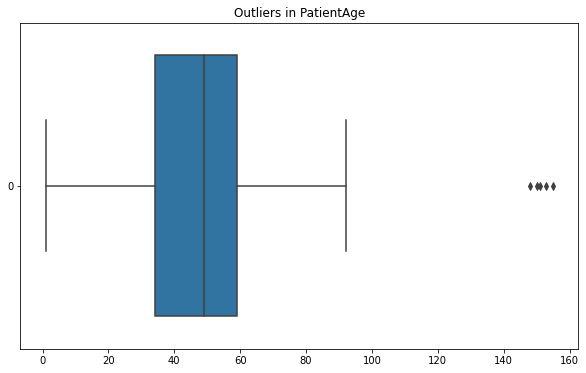

In [43]:
print('Checking outliers in `PatientAge'); print('--'*40)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class_df['PatientAge'].quantile(0.75) + (train_class_df['PatientAge'].quantile(0.75) - train_class_df['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class_df['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

In [44]:
print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*40)
train_class_df['PatientAge'] = train_class_df['PatientAge'].clip(train_class_df['PatientAge'].min(), 100)
train_class_df['PatientAge'].describe().astype(int)

Using pd.clip to set upper threshold of 100 for age and remove outliers
--------------------------------------------------------------------------------


count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int64

Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------


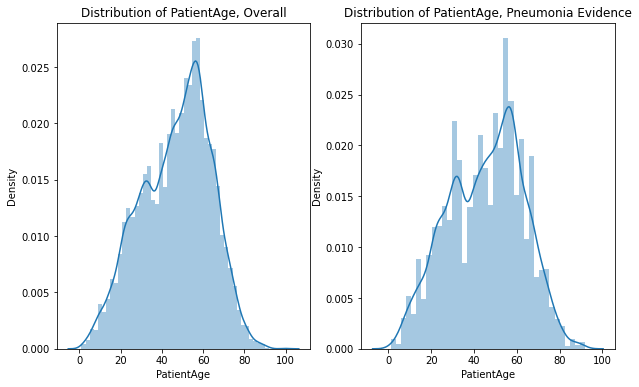

In [45]:
print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class_df['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class_df.loc[train_class_df['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))

#### Using Binning Method for PatientAge feature

We'll make use of a pd.cut which is 'Bin values into discrete intervals'. Use of this method is recommended when need is to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. Supports binning into an equal number of bins, or a pre-specified array of bins.

In [46]:
print('Creating Age Binning field', '--'*40)
train_class_df['AgeBins'] = pd.cut(train_class_df['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class_df['AgeBins'].value_counts()

Creating Age Binning field --------------------------------------------------------------------------------


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

In [ ]:
print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class_df['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class_df.loc[train_class_df['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class_df['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class_df.loc[train_class_df['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

In [ ]:
print('Exploring the bounding boxes centers for `AgeBins` for random sample = 200')
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class_df[train_class_df['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '<=26'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')


In [ ]:
print('Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender'); print('--'*40)
display(pd.concat([train_class_df['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class_df.loc[(train_class_df['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class_df.loc[(train_class_df['Target'] == 1) & (train_class_df['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class_df.loc[(train_class_df['Target'] == 1) & (train_class_df['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class_df['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class_df.loc[(train_class_df['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

In [ ]:

print('Exploring the bounding boxes centers for `PatientSex` for random sample = 1000')
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')


#### Observations: PatientAge & PatientSex Above we saw,

For PatientAge we saw the distribution for both overall and where there were evidence of Pneumonia. Used binning to check the count of age bins. Count was highest for age group 40-78 both overall and with Pneumonia Evidence. Saw distribution of age for Male and Female with Pneumonia Evidence. Dataset had more Males (57%-58%) than Females (42%-43%). Only PatientAge, PatientSex and ViewPosition are useful features from metadata.

Dropping the other features from train_class dataframe and save that as a pickle file

In [ ]:
train_class_df.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
train_class_df.to_pickle('train_class_features.pkl')
display(train_class_df.shape, train_class_df.head())

In [ ]:
print('Checking sample for different classes')
sample1 = train_class_df.loc[train_class_df['class'] == 'Normal'].iloc[0]
sample2 = train_class_df.loc[train_class_df['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class_df.loc[train_class_df['class'] == 'Lung Opacity'].iloc[1]
ds1 = pydicom.dcmread(sample1['path'])
ds2 = pydicom.dcmread(sample2['path'])
ds3 = pydicom.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()


In [ ]:

sample4 = train_class_df.loc[(train_class_df['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class_df.loc[(train_class_df['ViewPosition'] == 'PA')].iloc[0]
ds4 = pydicom.dcmread(sample4['path'])
ds5 = pydicom.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

In [ ]:
# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = pydicom.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = pydicom.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

In [ ]:
# this function is a part of custom module imported earlier (`eda`)
plot_dicom_images(data = train_class_df.loc[(train_class_df['Target'] == 1)].sample(9), 
                  df = train_class_df, img_path = TRAIN_IMG_DCM)

### Now we will convert the images from dcm to jpg for faster processing of data

In [ ]:
def convertImage(folder_path, jpg_folder_path):
    if not os.path.exists(jpg_folder_path): 
        os.makedirs(jpg_folder_path)
    images_path = os.listdir(folder_path)
    for n, image in tqdm_notebook(enumerate(images_path)):
        ds = pydicom.dcmread(os.path.join(folder_path, image))
        pixel_array_numpy = ds.pixel_array
        image = image.replace('.dcm', '.jpg')
        cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)

#### Convert all training images

In [ ]:
if os.listdir(TRAIN_IMG_DIR_JPG) == []: 
    print("No files found in the directory.") 
    convertImage(TRAIN_IMG_DCM, TRAIN_IMG_DIR_JPG)

#### Convert all test images

In [ ]:
if os.listdir(TRAIN_IMG_DIR_JPG) == []: 
    print("No files found in the directory.") 
    convertImage(TEST_IMG_DCM, TEST_IMG_DIR_JPG)

## Read data and Preparation for Model

In [ ]:
ALPHA = 1
IMAGE_SIZE = 1024
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
train_class_df.head(5)

In [ ]:
train_class_df['x2']=train_class_df['x'] + train_class_df['width']
train_class_df['y2']=train_class_df['y'] + train_class_df['height']
train_class_df.rename(columns = {'x':'x1'}, inplace = True)
train_class_df.rename(columns = {'y':'y1'}, inplace = True)

In [ ]:
train_class_reduced_df = train_class_df.sample(frac = 0.02) 

In [ ]:
train_class_reduced_df.shape

In [ ]:
train_class_reduced_df.head()

In [ ]:
def dropFeatures(train_class_updt_df):
    train_class_reduced_df = train_class_updt_df[['path', 'x1', 'y1','x2','y2','Target']].copy(deep = True)
    train_class_reduced_df['path'] = (train_class_reduced_df['path']
                                 .str.replace('stage_2_train_images', 'JPG_train')
                                 .str.replace('.dcm', '.jpg'))
    print('Distribution of target in the training set:'); 
    display(pd.Series(train_class_reduced_df['Target']).value_counts())
    train_class_reduced_df = train_class_reduced_df.reset_index()
    return train_class_reduced_df

In [ ]:
train_class_updt_df = dropFeatures(train_class_reduced_df)

### We need to handle imbalance hence we are going to delete non pneumonic person from the dataset

In [ ]:
def downSample(train_class_updt_df):
    df_majority = train_class_updt_df[train_class_updt_df.Target==0]
    df_minority = train_class_updt_df[train_class_updt_df.Target==1]
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0],     # to match minority class
                                     random_state=0) # reproducible results

    # Combine minority class with downsampled majority class
    df_majority_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    display(df_majority_downsampled.Target.value_counts())
    df_majority_downsampled = df_majority_downsampled.reset_index()
    return df_majority_downsampled

In [ ]:
train_class_reduced_df = downSample(train_class_updt_df)

In [ ]:
train_class_reduced_df.head(5)

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
def maskImage(train_class_updt_df):
    masks = np.zeros((int(train_class_updt_df.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
    X = np.zeros((int(train_class_updt_df.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    for index in tqdm_notebook(range(train_class_updt_df.shape[0])):
        img = load_image(train_class_updt_df['path'][index])
        img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
        try:
          img = img[:, :, :3]
        except:
          continue
        x1 = train_class_updt_df['x1'][index]   
        y1 = train_class_updt_df['y1'][index]
        x2 = train_class_updt_df['x2'][index]
        y2 = train_class_updt_df['y2'][index]
        X[index] = preprocess_input(np.array(img, dtype=np.float32))
        
        x1 = int((x1 * IMAGE_WIDTH) / IMAGE_SIZE) 
        x2 = int((x2 * IMAGE_WIDTH) / IMAGE_SIZE)   
        y1 = int((y1 * IMAGE_HEIGHT) / IMAGE_SIZE) 
        y2 = int((y2 * IMAGE_HEIGHT) / IMAGE_SIZE) 
        masks[index][y1:y2, x1:x2] = 1
    return X, masks

In [ ]:
X, masks = maskImage(train_class_reduced_df)

X.shape

In [ ]:
masks.shape

In [ ]:
def viewImage(n, X, y):
    f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
    ax1.imshow(X[n], cmap = plt.cm.bone)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(y[n], cmap = plt.cm.bone)
    ax2.set_title('Masked Image')
    ax2.axis('off')
    plt.show()

In [ ]:
def splitData(X, masks,n):
    return X[0:n], masks[0:n],X[n:], masks[n:] 

In [ ]:
#X_train, y_train, X_test, y_test = splitData(X, masks,25000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.20, random_state=0)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
viewImage(1, X_train, y_train)

In [ ]:
viewImage(10, X_train, y_train)

In [ ]:
X_train.shape

## Model 1 : Predict Bounding Boxes

### a) Mobile Net

In [ ]:
def createMobileNetModel(trainable=True):
    mobnet = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in mobnet.layers:
        layer.trainable = trainable

    block1 = mobnet.get_layer("conv_pw_5_relu").output
    block2 = mobnet.get_layer("conv_pw_11_relu").output
    block3 = mobnet.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = UpSampling2D()(x)
    x = UpSampling2D()(x)
    x = UpSampling2D()(x)
    
    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=mobnet.input, outputs=x)

In [ ]:
model = createMobileNetModel(False)
model.summary()

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
model.fit(X_train, y_train, epochs = 30, 
          batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

In [ ]:
scores = model.evaluate(X_test, y_test, verbose = 1)

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

In [ ]:
y_pred = model.predict(X_test, verbose = 1)

In [ ]:
viewImage(3, X_test, y_pred)

#### b) Mobile Net with additional layers

In [ ]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def createMobileNetModel2(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output

    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)
    return Model(inputs = model.input, outputs = x)

In [ ]:
model = createMobileNetModel2(False)
model.summary()

In [ ]:
model.compile(loss = loss, optimizer = optimizer, metrics = [dice_coefficient])
model.fit(X_train, y_train, 
           epochs = 30, batch_size = 32, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

In [ ]:
scores = model.evaluate(X_test, y_test, verbose = 1)

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

In [ ]:
y_pred = model.predict(X_test, verbose = 1)

In [ ]:
viewImage(3, X_test, y_pred)

## Model 2: Predict Pneumonia

In [ ]:
path_class_reduced_target = train_class_df.sample(frac = 0.02) 

In [ ]:
path_class_reduced_target = downSample(path_class_reduced_target)

In [ ]:
path_class_reduced_target.head()

In [ ]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = path_class_reduced_target[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'JPG_train')
                             .str.replace('.dcm', '.jpg'))
path_class_target.drop_duplicates(inplace = True)
path_class_reduced_df = path_class_target.reset_index()
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_reduced_df['Target'].value_counts())
print()
display(path_class_reduced_df['class'].value_counts())

In [ ]:
#path_class_target.head(10)

In [ ]:
#path_class_reduced_df = path_class_target.sample(frac = 0.02) 

In [ ]:
#path_class_reduced_df.shape

In [ ]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_reduced_df['path'])
random.shuffle(image_list)
test_size = round(len(image_list)/10)
val_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

In [ ]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_reduced_df.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_reduced_df.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_reduced_df.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTrain:{}\nValid:{}\nTest:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

In [ ]:
df_train.shape

In [ ]:
df_train.head()

In [ ]:
df_train.info()

In [ ]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

In [ ]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle('train_data.pkl')
df_valid.to_pickle('valid_data.pkl')
df_test.to_pickle('test_data.pkl')

In [ ]:
# Data generator
class DataGenerators:
    def __init__(self, df_train, df_valid, df_test, batch_size, path,
                 img_size = (224, 224), class_mode = 'binary',
                 random_state = 2020):
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        self.batch_size = batch_size
        self.img_size = img_size
        self.path = path
        self.class_mode = class_mode
        
        train_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rotation_range = 20, width_shift_range = 0.2,
            height_shift_range = 0.2, zoom_range = 0.2,
            horizontal_flip = True, rescale = 1/255.
            )
        
        valid_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input, 
            rescale = 1/255.
            )
        
        test_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rescale = 1/255.
            )
        
        print('Train Generator Created', '--'*20)
        self.train_generator = train_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_train,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = True
            )
        print('Validation Generator Created', '--'*20)
        self.valid_generator = valid_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_valid,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        print('Test Generator Created', '--'*20)
        self.test_generator = test_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_test,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        
        self.step_size_train = math.ceil(
            self.train_generator.n//self.train_generator.batch_size + 1
            )
        self.step_size_valid = math.ceil(
            self.valid_generator.n//self.valid_generator.batch_size + 1
            )
        self.step_size_test = math.ceil(
            self.test_generator.n//self.test_generator.batch_size + 1
            )

In [ ]:
df_train['Target'] = df_train['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [ ]:
df_train.head(3)

In [ ]:
TRAIN_IMAGES_DIR = os.path.join('/Volumes/Ayon_Drive/GreatLearning/Capstone_Pneumonia/')

In [ ]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = 32, 
                            path = TRAIN_IMAGES_DIR, 
                            img_size = (224, 224), 
                            class_mode = 'binary',
                            random_state = 2020)

In [ ]:
# ROC AUC as a Metric
# Reference: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def roc_auc(y_true, y_pred):
    return tf.compat.v1.py_function(roc_auc_score, (y_true, y_pred), tf.double)

# Average Precision as a Metric
import tensorflow.keras.backend as K
def average_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1 score as a Metric
# Reference: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision, f1_score]

In [ ]:
def buildModel(MODEL):
    #print('Create a' + str(MODEL) + ' model'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = MODEL(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    for layer in base_model.layers[:-12]:
        layer.trainable = False
    
    for layer in base_model.layers:
        print(layer,layer.trainable)
    
    model = Sequential(name = 'DenseNet121')
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def buildModel1():
    #print('Create a' + str(MODEL) + ' model'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = VGG16(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    for layer in base_model.layers[:-12]:
        layer.trainable = False
    
    for layer in base_model.layers:
        print(layer,layer.trainable)
    
    model = Sequential(name = 'DenseNet121')
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callback_model():
    print("in call backs")
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    
    callbacks = [cp, csv_logger, lrscheduler]
    return callbacks

def evaluateValidationData(model):
    
    ##Evaluate on validation data
    print('Evaluate the model on validation data'); print('--'*40)

    loss, accuracy, ap, f1 = model.evaluate_generator(generator = validation_generator, 
                                          steps = generators.step_size_valid)
    print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)},  AP: {round(float(ap), 3)}, F1 Score: {round(float(f1), 3)}')
    
    ##Prediction on validation data
    print('Predict on the validation data'); print('--'*40)
    validation_generator.reset()
    valid_pred_roc = model.predict_generator(generator = validation_generator,
                                             steps = generators.step_size_valid,
                                             verbose = 1)
    valid_pred = []
    for i in valid_pred_roc:
        if i >= 0.5: valid_pred.append(1)
        else: valid_pred.append(0)
    y_valid = df_valid['Target'].astype(int).values
    x_valid = df_valid['path']
    
    return valid_pred, y_valid, x_valid

def evaluateTestData(y_valid):
    
    ##Prediction on test data
    print('Predict on the test data'); print('--'*40)
    test_generator.reset()
    test_pred_roc = model.predict_generator(generator = test_generator,
                                            steps = generators.step_size_test,
                                            verbose = 1)
    test_pred = []
    for i in test_pred_roc:
        if i >= 0.5: test_pred.append(1)
        else: test_pred.append(0)
    y_test = df_test['Target'].astype(int).values
    x_test = df_test['path']
          
    display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())
    
    correct = np.nonzero(test_pred == y_test)[0]
    incorrect = np.nonzero(test_pred != y_test)[0]
    percentage = ((correct.size)/(correct.size + incorrect.size)) * 100
    
    print("Correctly predicted %d images out of %d images" %(correct.size, correct.size+incorrect.size))
    print("Predicted %.0f%% test images correctly" %(correct.size/(correct.size+incorrect.size)*100))
    
    return test_pred, y_test, x_test, correct, incorrect

def evaluateROC(valid_pred_roc,test_pred_roc,y_valid,y_test):
    
    print('ROC Curve for the validation data'); print('--'*40)

    roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
    print('AUC: {:0.3f}'.format(roc_auc_valid))

    fig = plt.figure(figsize = (10, 7.2))
    fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
    plt.title('ROC Curve for the validation data')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
    plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
    plt.legend(loc = 'lower right')
    plt.show()
          
    print('ROC Curve for the test data'); print('--'*40)

    roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
    print('AUC: {:0.3f}'.format(roc_auc_test))

    fig = plt.figure(figsize = (10, 7.2))
    fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
    plt.title('ROC Curve for the test data')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
    plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.show()
          
    print('Classification Report on the test data'); print('--'*60)
    print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))
          
    print('Classification Report on the validation data'); print('--'*60)
    print(classification_report(y_valid, valid_pred, target_names = ['Normal', 'Pneumonia']))

In [ ]:
MODEL_WEIGHTS = os.path.join('model_weights/')
if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

In [ ]:
print('Lets fit the model.....')
K.clear_session()
model = buildModel(DenseNet121)
callbacks = callback_model()
train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator    
history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch = generators.step_size_train,
                              epochs = EPOCH, verbose = VERBOSE, 
                              callbacks = callbacks,
                              validation_data = validation_generator, 
                              validation_steps = generators.step_size_valid)
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

In [ ]:
valid_pred, y_valid, x_valid = evaluateValidationData(model)

In [ ]:
test_pred, y_test, x_test, correct, incorrect = evaluateTestData(y_valid)

In [ ]:
def viewPredictedImage(correct):
    for c in correct[:4]:
        f, ((ax1)) = plt.subplots(1, 1, figsize = (15, 8))
        img = load_image(x_test[c])
        img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
        ax1.imshow(img, cmap = plt.cm.bone)
        ax1.set_title("Predicted Class {},Actual Class {}".format(valid_pred[c], y_test[c]))
        ax1.axis('off')
        plt.show()

In [ ]:
viewPredictedImage(correct)

In [ ]:
viewPredictedImage(incorrect)

In [ ]:
evaluateROC(valid_pred_roc,test_pred_roc,y_valid,y_test)

In [ ]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

### Model 2 VGG 16

In [ ]:
print('Lets fit the VGG16 model.....')
K.clear_session()
model = buildModel(VGG16)
callbacks = callback_model()
train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator    
history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch = generators.step_size_train,
                              epochs = EPOCH, verbose = VERBOSE, 
                              callbacks = callbacks,
                              validation_data = validation_generator, 
                              validation_steps = generators.step_size_valid)
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

In [ ]:
valid_pred, y_valid, x_valid = evaluateValidationData(model)

In [ ]:
test_pred, y_test, x_test, correct, incorrect = evaluateTestData(y_valid)

In [ ]:
viewPredictedImage(correct)

In [ ]:
viewPredictedImage(incorrect)

In [ ]:
evaluateROC(valid_pred_roc,test_pred_roc,y_valid,y_test)

In [ ]:


print('Lets fit the Restnet model.....')
K.clear_session()
model = buildModel(ResNet50)
callbacks = callback_model()
train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator    
history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch = generators.step_size_train,
                              epochs = EPOCH, verbose = VERBOSE, 
                              callbacks = callbacks,
                              validation_data = validation_generator, 
                              validation_steps = generators.step_size_valid)
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

In [ ]:
valid_pred, y_valid, x_valid = evaluateValidationData(model)


In [ ]:
test_pred, y_test, x_test, correct, incorrect = evaluateTestData(y_valid)


In [ ]:
viewPredictedImage(correct)


In [ ]:
viewPredictedImage(incorrect)


In [ ]:
evaluateROC(valid_pred_roc,test_pred_roc,y_valid,y_test)

In [ ]:
print('Lets fit the InceptionV3 model.....')
K.clear_session()
model = buildModel(InceptionV3)
callbacks = callback_model()
train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator    
history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch = generators.step_size_train,
                              epochs = EPOCH, verbose = VERBOSE, 
                              callbacks = callbacks,
                              validation_data = validation_generator, 
                              validation_steps = generators.step_size_valid)
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

In [ ]:
valid_pred, y_valid, x_valid = evaluateValidationData(model)
test_pred, y_test, x_test, correct, incorrect = evaluateTestData(y_valid)
viewPredictedImage(correct)
viewPredictedImage(incorrect)
evaluateROC(valid_pred_roc,test_pred_roc,y_valid,y_test)

In [ ]:
print('Lets fit the VGG19 model.....')
K.clear_session()
model = buildModel(VGG19)
callbacks = callback_model()
train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator    
history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch = generators.step_size_train,
                              epochs = EPOCH, verbose = VERBOSE, 
                              callbacks = callbacks,
                              validation_data = validation_generator, 
                              validation_steps = generators.step_size_valid)
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

In [ ]:
valid_pred, y_valid, x_valid = evaluateValidationData(model)


In [ ]:
test_pred, y_test, x_test, correct, incorrect = evaluateTestData(y_valid)


In [ ]:
viewPredictedImage(correct)


In [ ]:
viewPredictedImage(incorrect)


In [ ]:
evaluateROC(valid_pred_roc,test_pred_roc,y_valid,y_test)

In [ ]:
print('Lets fit the DenseNet169 model.....')
K.clear_session()
model = buildModel(DenseNet169)
callbacks = callback_model()
train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator    
history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch = generators.step_size_train,
                              epochs = EPOCH, verbose = VERBOSE, 
                              callbacks = callbacks,
                              validation_data = validation_generator, 
                              validation_steps = generators.step_size_valid)
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

In [ ]:
valid_pred, y_valid, x_valid = evaluateValidationData(model)


In [ ]:
test_pred, y_test, x_test, correct, incorrect = evaluateTestData(y_valid)


In [ ]:
viewPredictedImage(correct)


In [ ]:
viewPredictedImage(incorrect)


In [ ]:
evaluateROC(valid_pred_roc,test_pred_roc,y_valid,y_test)